# Set model to visualize
After setting these values, just run all cells. Double check data augmentation section.

In [1]:
# Model filename
model_fn = 'ResNet50_v2-fluo-batch16-lr0.1-step1-gamma0.7-epoch45.pt'

model_fn_bf = 'ResNet50_v2-bf-batch16-lr0.1-step1-gamma0.7-epoch45.pt'

### Set batch size and number of GPUs
 

In [5]:
per_device_batch_size = 1
num_gpus = 1
num_workers = 1
batch_size = per_device_batch_size * max(num_gpus, 1)

# Setup



### Import necessary packages

In [9]:
import numpy as np
import os, time, shutil
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from google.colab import files, drive   

# Data

### Mount Google Drive

In [10]:
drive.mount('/content/gdrive')
print(os.listdir('/content/gdrive/My Drive/'))

Mounted at /content/gdrive
['cs101', 'Getting started.pdf', 'Colab Notebooks', 'embryo_13_fluo_sequence.mp4', 'embryo_13_fluo_slice.mp4', 'embryo_13_bf_slice.mp4', 'embryo_13_bf_sequence.mp4', 'hi', 'embryo data.gsheet', 'classify_fluo_pretrained.ipynb', 'classify_fluo_CNN_2.ipynb', 'Copy of Pyramid Principle Exercise.gslides', 'dloss_100.npy', 'gloss_100.npy', 'generator_100.pth', 'discriminator_100.pth', 'ResNet50_v2-batch16-lr0.001-mom0.9-wd0.0001 (8)', 'ResNet50_v2-batch16-lr0.001-mom0 (2).9-wd0.0001-epoch0.params', 'ResNet50_v2-batch16-lr0.001-mom0 (2).9-wd0.0001-epoch1.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch2.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch3.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch4.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch5.params', 'ResNet50_v2-batch16-lr0.001-mom0 (1).9-wd0.0001-epoch6.params', 'ResNet50_v2-batch16-lr0.001-mom0.9-wd0.0001 (7)', 'ResNet50_v2-batch16-lr0.001-mom0

### Define filepaths

In [12]:
home_path = '/content/gdrive/Shared drives/Embryo_data'
processed_path = f'{home_path}/processed'

# Directories for input data
train_path = f'{processed_path}/pix2pix/train/fluo_data'
val_path = f'{processed_path}/pix2pix/val/fluo_data'
test_path = f'{processed_path}/pix2pix/test/fluo_data'

train_path_bf = f'{processed_path}/pix2pix/train/bf_data'
val_path_bf = f'{processed_path}/pix2pix/val/bf_data'
test_path_bf = f'{processed_path}/pix2pix/test/bf_data'

### Data augmentation

In [13]:
transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

### Define data loader

In [14]:
class ImageFolderDataset(Dataset):
    """A dataset for loading image files stored in a folder structure.

    like::

        root/car/0001.jpg
        root/car/xxxa.jpg
        root/car/yyyb.jpg
        root/bus/123.jpg
        root/bus/023.jpg
        root/bus/wwww.jpg

    Parameters
    ----------
    root : str
        Path to root directory.
    flag : {0, 1}, default 1
        If 0, always convert loaded images to greyscale (1 channel).
        If 1, always convert loaded images to colored (3 channels).
    transform : callable, default None
        A function that takes data and label and transforms them::

            transform = lambda data, label: (data.astype(np.float32)/255, label)

    Attributes
    ----------
    synsets : list
        List of class names. `synsets[i]` is the name for the integer label `i`
    items : list of tuples
        List of all images in (filename, label) pairs.
    """
    def __init__(self, root, flag=1, transform=None):
        self._root = os.path.expanduser(root)
        self._flag = flag
        self._transform = transform
        self._exts = ['.jpg', '.jpeg', '.png']
        self._list_images(self._root)

    def _list_images(self, root):
        self.items = []

        for filename in sorted(os.listdir(root)):
          filepath = os.path.join(root, filename)
          self.items.append(filepath)

    def __getitem__(self, idx):
        ind = self.items[idx].find('embryo')
        [embryo_num, embryo_t, label] = [int(num) for num in self.items[idx][ind:-4].split('_')[1:]]
        img = Image.open(self.items[idx]).convert('RGB')
        if self._transform is not None:
            img = self._transform(img)
        return {'img': img, 'label': label, 'embryo_num': embryo_num, 'embryo_t': embryo_t}

    def __len__(self):
        return len(self.items)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

# Fluo
train_dataset = ImageFolderDataset(train_path, transform=transform_train)
val_dataset = ImageFolderDataset(val_path, transform=transform_train)
test_dataset = ImageFolderDataset(test_path, transform=transform_test)

train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Bf
train_dataset_bf = ImageFolderDataset(train_path_bf, transform=transform_train)
val_dataset_bf = ImageFolderDataset(val_path_bf, transform=transform_train)
test_dataset_bf = ImageFolderDataset(test_path_bf, transform=transform_test)

train_data_bf = DataLoader(train_dataset_bf, batch_size=batch_size, shuffle=True, **kwargs)
val_data_bf = DataLoader(val_dataset_bf, batch_size=batch_size, shuffle=True, **kwargs)
test_data_bf = DataLoader(test_dataset_bf, batch_size=batch_size, shuffle=False, **kwargs)

# Model


In [18]:
classes = 2

# Fluo
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, classes)
model.to(device)
model_fp = os.path.join(home_path, 'models', 'best', model_fn)
model.load_state_dict(torch.load(model_fp))

# Bf
model_bf = models.resnet50(pretrained=True)
model_bf.fc = torch.nn.Linear(model_bf.fc.in_features, classes)
model_bf.to(device)
model_fp_bf = os.path.join(home_path, 'models', 'best', model_fn_bf)
model_bf.load_state_dict(torch.load(model_fp_bf))

<All keys matched successfully>

### Calculate test accuracy

In [21]:
# define an evaluation function for validation and testing

def test(model, device, test_loader):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data0 in test_loader:
            data = data0['img']
            target = data0['label']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += len(target)

    test_loss /= total

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, total,
        100. * correct / total))
    return test_loss, correct / total

# run on test data (fluo)
_, test_acc = test(model, device, test_data)
print('[Finished] Test-acc: %.3f' % (test_acc))

# run on test data (bf)
_, test_acc_bf = test(model_bf, device, test_data_bf)
print('[Finished] Test-acc: %.3f' % (test_acc_bf))


Test set: Average loss: 0.0985, Accuracy: 430/449 (96%)

[Finished] Test-acc: 0.958

Test set: Average loss: 0.4137, Accuracy: 402/449 (90%)

[Finished] Test-acc: 0.895


# Visualize

### Summarize test prediction results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Text(0, 0.5, 'Label')

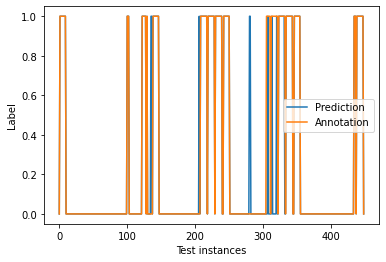

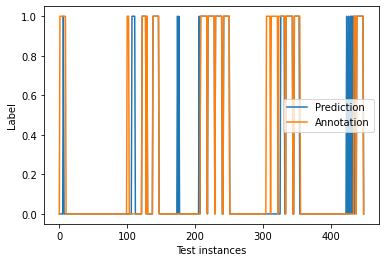

In [42]:
# summarize test prediction results (fluo)
record_pred = []
record_label = []
record_fn = []
for data0 in test_data:
  data = data0['img']
  label = data0['label']
  embryo_num = data0['embryo_num']
  embryo_t = data0['embryo_t']
  data, label, embryo_num, embryo_t = data.to(device), label.to(device), embryo_num.to(device), embryo_t.to(device)
  fp = [os.path.join(test_path, str(label[j].cpu().numpy()), f'embryo_{str(embryo_num[j].cpu().numpy())}_{str(embryo_t[j].cpu().numpy())}.png') for j in range(len(embryo_num))]
  outputs = model(data)
  a = outputs.argmax(dim=1, keepdim=True).cpu().detach().numpy()
  b = label.cpu().detach().numpy()
  if record_pred == []:
    record_pred = a
    record_label = b
    record_fn = fp
  else:
    record_pred = np.concatenate((record_pred, a), axis=0)
    record_label = np.concatenate((record_label, b), axis=0)
    record_fn = np.concatenate((record_fn, fp), axis=0)

plt.figure()
plt.plot(np.arange(len(record_pred)),record_pred,label='Prediction')
plt.plot(np.arange(len(record_label)),record_label,label='Annotation')
plt.legend()
plt.xlabel('Test instances')
plt.ylabel('Label')

# summarize test prediction results (bf)
record_pred_bf = []
record_label_bf = []
record_fn_bf = []
for data0 in test_data_bf:
  data = data0['img']
  label = data0['label']
  embryo_num = data0['embryo_num']
  embryo_t = data0['embryo_t']
  data, label, embryo_num, embryo_t = data.to(device), label.to(device), embryo_num.to(device), embryo_t.to(device)
  fp = [os.path.join(test_path, str(label[j].cpu().numpy()), f'embryo_{str(embryo_num[j].cpu().numpy())}_{str(embryo_t[j].cpu().numpy())}.png') for j in range(len(embryo_num))]
  outputs = model_bf(data)
  a = outputs.argmax(dim=1, keepdim=True).cpu().detach().numpy()
  b = label.cpu().detach().numpy()
  if record_pred_bf == []:
    record_pred_bf = a
    record_label_bf = b
    record_fn_bf = fp
  else:
    record_pred_bf = np.concatenate((record_pred_bf, a), axis=0)
    record_label_bf = np.concatenate((record_label_bf, b), axis=0)
    record_fn_bf = np.concatenate((record_fn_bf, fp), axis=0)

plt.figure()
plt.plot(np.arange(len(record_pred_bf)),record_pred_bf,label='Prediction')
plt.plot(np.arange(len(record_label_bf)),record_label_bf,label='Annotation')
plt.legend()
plt.xlabel('Test instances')
plt.ylabel('Label')

### Confusion matrix

[[310  14]
 [ 33  92]]


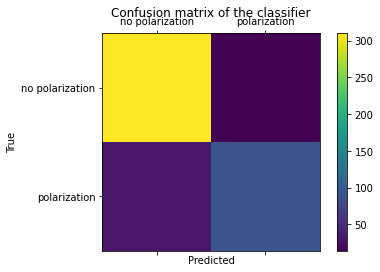

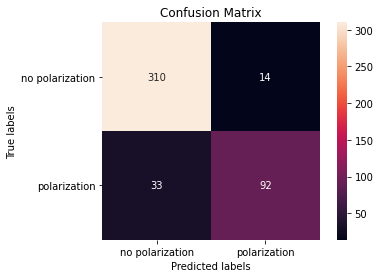

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['no polarization','polarization']
cm = confusion_matrix(record_label, record_pred)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt="d", ax=ax) # annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['no polarization', 'polarization'])
ax.yaxis.set_ticklabels(['no polarization', 'polarization'], rotation='horizontal')
ax.set_aspect('equal', 'box')

### Attention of CNN

This section refers to https://discuss.mxnet.io/t/how-to-visualize-image-classification-resnetv2/4969

Another similar realization can be seen in https://github.com/nicklhy/CAM/blob/master/cam.ipynb

About Class Activation Maps(CAM):
https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-class-activation-maps-fe94eda4cef1

In [65]:
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

def returnCAM(feature_conv, weight_softmax, idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    print(weight_softmax[idx].shape, feature_conv.reshape((nc, h*w)).shape)
    cam = np.matmul(weight_softmax[idx], feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    return cv2.resize(cam, size_upsample)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def collapse_same_frame(images):
  delete_idx = []
  for i in range(images.shape[-1]):
    img1 = images[:,:,i]
    for j in range(i+1,images.shape[-1]):
      img2 = images[:,:,j]
      if np.array_equal(img1,img2):
        delete_idx.append(j) 
  images_return = np.delete(images,np.unique(np.asarray(delete_idx)),-1)
  return images_return 

# define a helper to display multiple images in a row in notebook
def show_images(images, titles, cmaps, vmin_lst, vmax_lst):
    num_images = len(images)
    rows, cols = 1, num_images

    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    for i in range(num_images):
        img = images[i]
        vmin = vmin_lst[i]
        vmax = vmax_lst[i]
        axs[i].set_title(titles[i])

        if len(img.shape)==2:
          im = axs[i].imshow(img, cmap=cmaps[i], vmin=vmin, vmax=vmax)
          # create an axes on the right side of ax. The width of cax will be 5%
          # of ax and the padding between cax and ax will be fixed at 0.05 inch.
          divider = make_axes_locatable(axs[i])
          cax = divider.append_axes("right", size="5%", pad=0.05)
          # norm = mpl.colors.Normalize(vmin=-5, vmax=10)
          # cb1 = mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.gist_rainbow,
          #                       norm=norm,
          #                       orientation='vertical')
          plt.colorbar(im, cax=cax)
        else:
          im = axs[i].imshow(img, cmap=cmaps[i])
    return fig

In [78]:
def find_heatmap_and_test_image(finetune_net, test_image, test_label, model_name):
  output = finetune_net(test_image)
  classes = ['no polarization','polarization']
  idx = outputs.argmax(dim=1, keepdim=True)

  features_blob, weight_softmax = find_resnet_features(finetune_net, test_image, model_name)

  CAMs = returnCAM(features_blob, weight_softmax, idx)
  _ , _ , height, width = test_image.shape
  test_CAM = cv2.resize(CAMs,(width, height))
  print('Annotated label: %s'%classes[int(test_label)])
  print('Network prediction: %s'%classes[idx])

  # convert <NDArray 1x3x512x512 @gpu(0)> to <NumArray 512x512x3 @memory>
  test_image_narray = np.swapaxes(np.swapaxes(np.squeeze(test_image.asnumpy()),0,2), 0, 1)
  test_image_narray = (NormalizeData(test_image_narray)*255).astype(np.uint8)

  test_image_squeeze = np.squeeze(collapse_same_frame(test_image_narray))

  return test_CAM, test_image_squeeze, idx


def find_resnet_features(finetune_net, test_image, model_name):
  if model_name.lower() == 'resnet50_v2':
    params = list(finetune_net.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
    print(*list(finetune_net.children())[-1])
    mod = nn.Sequential(list(finetune_net.children())[:-1]).to(device)
    features_blob = mod(test_image).cpu().detach().numpy()
  else:
    raise Exception('Model name {} not recognized'.format(model_name))
  print(features_blob, weight_softmax)
  return features_blob, weight_softmax


def visualize_CAM_and_fluo_data(test_CAM_lst, test_image_squeeze_lst, im_type_lst, fig_title_lst):
  assert(len(test_CAM_lst) == len(test_image_squeeze_lst))
  assert(len(test_CAM_lst) == len(im_type_lst))
  assert(len(test_CAM_lst) == len(fig_title_lst))

  # Find min and max of all images to visualize for color map
  vmin = min([np.min(test_CAM) for test_CAM in test_CAM_lst])
  vmax = max([np.max(test_CAM) for test_CAM in test_CAM_lst])

  for i in range(len(test_CAM_lst)):
    test_CAM = test_CAM_lst[i]
    test_image_squeeze = test_image_squeeze_lst[i]
    im_type = im_type_lst[i]
    fig_title = fig_title_lst[i]
    images = []
    images.append(test_CAM)
    images.append(cv2.equalizeHist(cv2.cvtColor(test_image_squeeze,cv2.COLOR_BGR2GRAY)))

    titles = [fig_title + ' CAM', 'CAM+' + im_type, im_type]
    cmaps = ['seismic', None]
    vmin_lst = [vmin, None]
    vmax_lst = [vmax, None]
    fig = show_images(images, titles, cmaps, vmin_lst, vmax_lst)

#### Specify test image

In [47]:
def find_class(file_path, embryo_num, embryo_t, classes_dirs):
  fn = None
  for cl in classes_dirs:
    fn_new = os.path.join(file_path, f'embryo_{embryo_num}_{embryo_t}_{cl}.png')
    if os.path.isfile(fn_new):
      return cl
  return

In [79]:
classes_dirs = ['0', '1']

embryo_num_lst = [24]
embryo_t_lst = [0]
model_name = 'resnet50_v2'


test_CAM_lst, test_image_squeeze_lst, im_type_lst, fig_title_lst = [], [], [], []
for i in range(len(embryo_num_lst)):
  embryo_num = embryo_num_lst[i]
  embryo_t = embryo_t_lst[i]

  # Fluo
  im_type = 'Fluorescence'
  test_label = find_class(test_path, embryo_num, embryo_t, classes_dirs)
  test_image_fn = os.path.join(test_path, f'embryo_{embryo_num}_{embryo_t}_{test_label}.png')
  test_image = torch.unsqueeze(transform_test(Image.open(test_image_fn).convert('RGB')), 0).to(device)

  test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(model, test_image, test_label, model_name)
  fig_title = f'{im_type} embryo {embryo_num} at t={embryo_t}, label {test_label}, annotated {test_annot}'

  test_CAM_lst.append(test_CAM)
  test_image_squeeze_lst.append(test_image_squeeze)
  im_type_lst.append(im_type)
  fig_title_lst.append(fig_title)

  # Bright field
  im_type = 'Bright field'
  test_label_bf = find_class(test_path_bf, embryo_num, embryo_t, classes_dirs)
  test_image_fn_bf = os.path.join(test_path_bf, f'embryo_{embryo_num}_{embryo_t}_{test_label_bf}.png')
  test_image_bf = torch.unsqueeze(transform_test(Image.open(test_image_fn_bf).convert('RGB')), 0).to(device)

  test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(model_bf, test_image_bf, test_label_bf, model_name)
  fig_title = f'{im_type} embryo {embryo_num} at t={embryo_t} (label {test_label_bf}, annotated {test_annot})'

  test_CAM_lst.append(test_CAM)
  test_image_squeeze_lst.append(test_image_squeeze)
  im_type_lst.append(im_type)
  fig_title_lst.append(fig_title)


visualize_CAM_and_fluo_data(test_CAM_lst, test_image_squeeze_lst, im_type_lst, fig_title_lst)

TypeError: ignored

#### Correct prediction

In [ ]:
group_id = 5 #3
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break

In [ ]:
# get an image
test_idx = 0 #15
test_image = data[0][test_idx].expand_dims(0)
test_label = label[0][test_idx].asnumpy()
print(test_image.shape, type(test_image))

(1, 3, 512, 512) <class 'mxnet.ndarray.ndarray.NDArray'>


Annotated label: no polarization
Network prediction: no polarization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


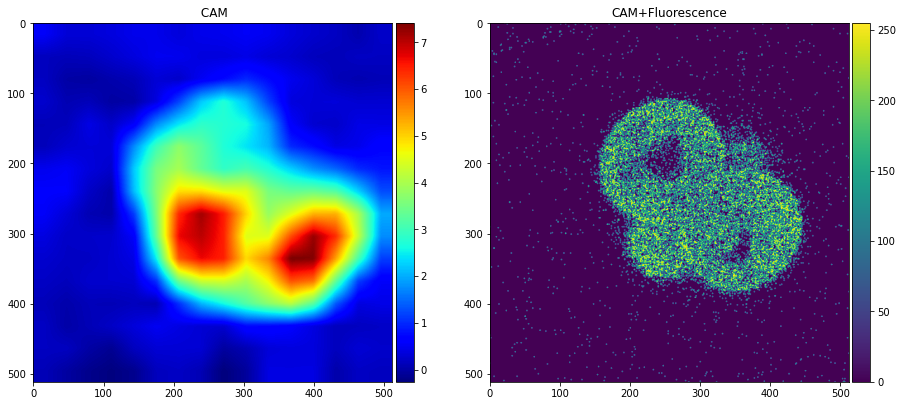

In [ ]:
test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(finetune_net, test_image, test_label, model_name)
visualize_CAM_and_fluo_data([test_CAM], [test_image_squeeze], ['Fluorescence'], [''])

#### Wrong prediction

In [ ]:
tp = record_pred==record_label
itemindex = np.where(tp==False)
print(itemindex)

(array([103, 105, 106, 107, 109, 111, 113, 118, 130]),)


In [ ]:
FN_idx = 1
group_id = np.floor(itemindex[0][FN_idx]/batch_size)
for i, batch in enumerate(test_data):
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
    if i == group_id:
      break
test_idx = np.remainder(itemindex[0][FN_idx], batch_size)

Annotated label: no polarization
Network prediction: no polarization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


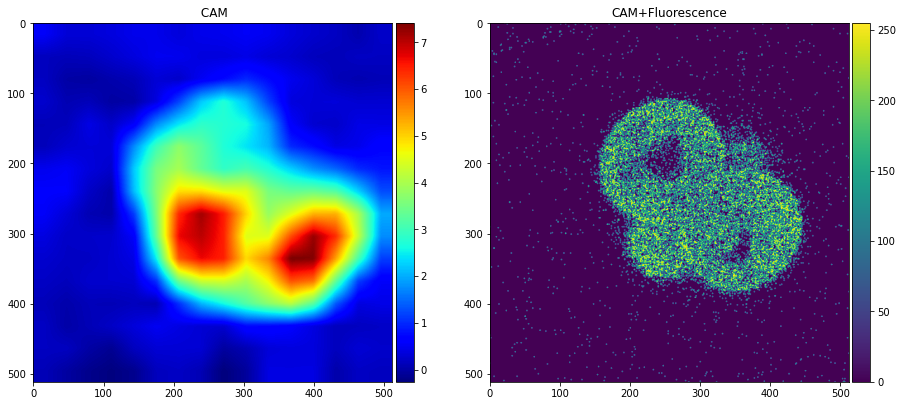

In [ ]:
test_CAM, test_image_squeeze, test_annot = find_heatmap_and_test_image(finetune_net, test_image, test_label, model_name)
visualize_CAM_and_fluo_data([test_CAM], [test_image_squeeze], ['Fluorescence'], [''])

In [ ]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        value = 128 + factor * (c - 128)
        return max(0, min(255, value))
    return img.point(contrast)


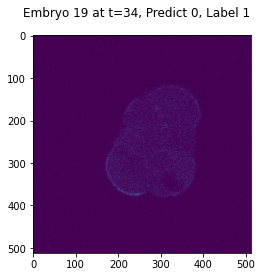

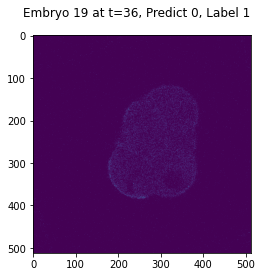

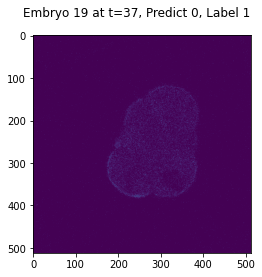

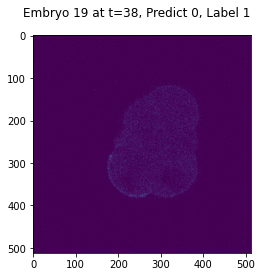

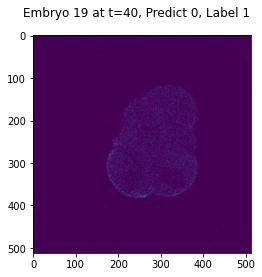

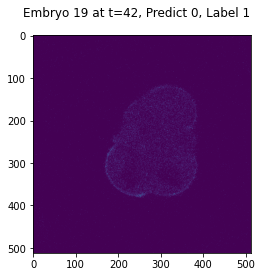

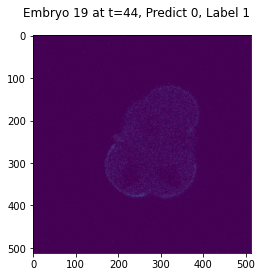

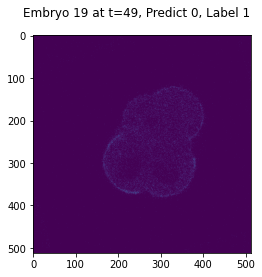

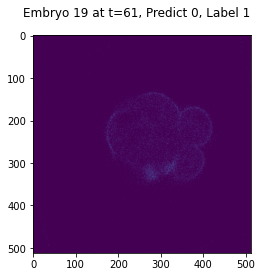

In [ ]:
for FN_idx in range(len(itemindex[0])):
  group_id = np.floor(itemindex[0][FN_idx]/batch_size)
  for i, batch in enumerate(test_data):
      data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
      label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
      if i == group_id:
        break
  test_idx = np.remainder(itemindex[0][FN_idx], batch_size)
  fn = record_fn[int(group_id)]
  im = Image.open(fn)
  fig = plt.figure()
  fn_lst = fn[:-4].split('_')
  embryo_num = int(fn_lst[-2])
  embryo_t = int(fn_lst[-1])
  fig.suptitle(f'Embryo {embryo_num} at t={embryo_t}, Predict {record_pred[int(group_id)]}, Label {record_label[int(group_id)]}')
  plt.imshow(im, vmin=0, vmax=255)